In [63]:
from datetime import datetime
import backtrader as bt
import matplotlib.pyplot as plt
import pyfolio as pf
%matplotlib inline
import pandas_datareader.data as web
import pandas as pd

def sim_leverage(proxy, leverage=1, expense_ratio = 0.0, initial_value=1.0):
    pct_change = proxy["Adj Close"].pct_change(1)
    sim = pd.DataFrame().reindex_like(proxy)
    pct_change = (pct_change - expense_ratio / 252) * leverage
    sim["Adj Close"] = (1 + pct_change).cumprod() * initial_value
    sim.loc[sim.index[0], "Adj Close"] = initial_value
    return sim

start = datetime(1989, 1, 1)
end = datetime(2019,1,1)
vfinx = web.DataReader("VFINX", "yahoo", start, end)
vusxt = web.DataReader("VUSTX", "yahoo", start, end)

upro_sim = sim_leverage(vfinx, leverage=3.0, expense_ratio=0.0092)["Adj Close"].rename("UPRO Sim")
upro_sim = upro_sim.to_frame(name="close")
upro_sim["open"] = upro_sim["close"]
upro_sim["high"] = upro_sim["close"]
upro_sim["low"] = upro_sim["close"]
upro_sim["volume"] = 0
upro_sim.head()

tmf_sim = sim_leverage(vusxt, leverage=3.0, expense_ratio=0.0111)["Adj Close"].rename("TMF Sim")
tmf_sim = tmf_sim.to_frame(name="close")
tmf_sim["open"] = tmf_sim["close"]
tmf_sim["high"] = tmf_sim["close"]
tmf_sim["low"] = tmf_sim["close"]
tmf_sim["volume"] = 0
tmf_sim.head()


,close,open,high,low,volume
Date,,,,,
1989-01-03,1.000000,1.000000,1.000000,1.000000,0
1989-01-04,1.003170,1.003170,1.003170,1.003170,0
1989-01-05,0.996421,0.996421,0.996421,0.996421,0
1989-01-06,1.006166,1.006166,1.006166,1.006166,0
1989-01-09,1.009347,1.009347,1.009347,1.009347,0


<IPython.core.display.Javascript object>


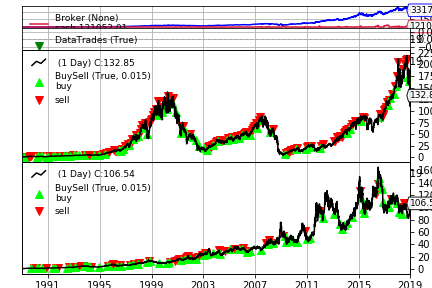

[[<Figure size 432x288 with 6 Axes>]]

In [85]:
class Strat(bt.Strategy):
    params = (
        ('split',50),
        )
    def __init__(self):
        self.UPRO = self.datas[0]
        self.TMF = self.datas[1]
        self.counter = 0
        
    def next(self):
        if  self.counter % 20 == 0:
            self.order_target_percent(self.UPRO, target=(self.params.split / 100 - 0))
            self.order_target_percent(self.TMF, target=(1 - self.params.split / 100 - 0))
        self.counter += 1


cerebro = bt.Cerebro()

start = datetime(1989, 1, 1)
end = datetime(2019, 1, 1)

upro = bt.feeds.PandasData(dataname=upro_sim)
tmf = bt.feeds.PandasData(dataname=tmf_sim)
#tmf = bt.feeds.YahooFinanceCSVData(dataname='../data/TMF_SIM.csv')

                                 
cerebro.adddata(upro)
cerebro.adddata(tmf)

cerebro.addstrategy(Strat, split=50)

# strats = cerebro.optstrategy(
#         Strat,
#         split=range(50, 51))


cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio') 
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name='sharpe')
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')



cerebro.broker.setcommission(commission=0.0)

results = cerebro.run()

cerebro.plot()


In [86]:
results[0].analyzers.sharpe.get_analysis()

OrderedDict([('sharperatio', 0.7286412705379419)])

In [87]:
results[0].analyzers.returns.get_analysis()

OrderedDict([('rtot', 5.804265568325193),
             ('ravg', 0.0007677599958102108),
             ('rnorm', 0.21345967941371485),
             ('rnorm100', 21.345967941371484)])

In [88]:
results[0].analyzers.drawdown.get_analysis()

AutoOrderedDict([('len', 234),
                 ('drawdown', 17.33899347088417),
                 ('moneydown', 695798.8420925802),
                 ('max',
                  AutoOrderedDict([('len', 1072),
                                   ('drawdown', 46.34453335067618),
                                   ('moneydown', 964775.0482834252)]))])

Start date,1989-01-03
End date,2019-01-02
Total months,360
,Backtest
Annual return,21.3%
Cumulative returns,33071.1%
Annual volatility,24.5%
Sharpe ratio,0.91
Calmar ratio,0.46
Stability,0.95
Max drawdown,-46.3%


<IPython.core.display.Javascript object>


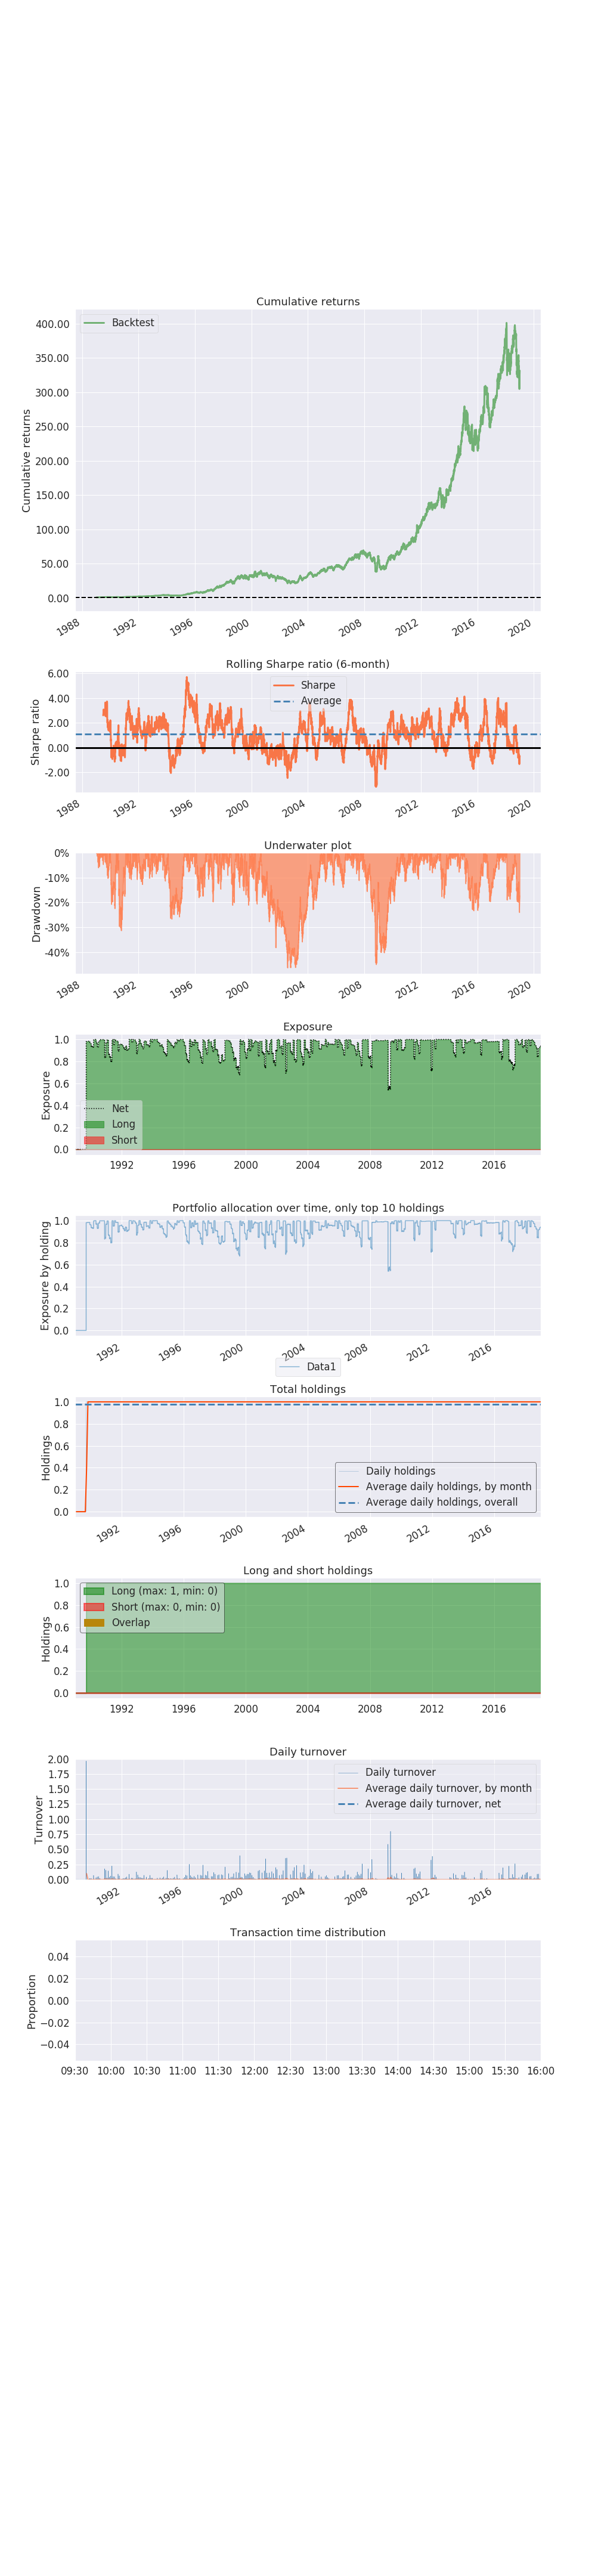

In [89]:

strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
pf.create_simple_tear_sheet(returns, positions=positions, transactions=transactions)